In [ ]:
!nvidia-smi

Tue Apr 25 08:08:12 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!python --version
!pip install transformers --quiet
!pip install pytorch-lightning --quiet

Python 3.9.16
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 69.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 98.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.2/224.2 kB 26.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.0/719.0 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 49.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 67.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 kB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 kB 19.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 269.3/269.3 kB 22.8 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np

from tqdm.auto import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from transformers import BertTokenizerFast as BertTokenizer, BertModel, AutoTokenizer, AutoModel, AdamW, get_linear_schedule_with_warmup

import pytorch_lightning as pl
from torchmetrics.functional import auroc, accuracy
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, multilabel_confusion_matrix
from sklearn.model_selection import KFold

import seaborn as sns        
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc

#Import Train / Test Data

In [ ]:
!gdown --id 1TjVUD5MRPqlAjINhFfRM2vJpB0iaZm6w

In [ ]:
df1 = pd.read_csv("cleaned_train_data_v1_subtaskA.csv")
df1.head()

,del,id,tweet,subtask_a,subtask_b,subtask_c,cleaned_tweet
0,0,86426,@USER She should ask a few native Americans wh...,OFF,UNT,NaN,ask native americans take
1,1,90194,@USER @USER Go home you’re drunk!!! @USER #MAG...,OFF,TIN,IND,go home drunk maga trump 2020
2,2,16820,Amazon is investigating Chinese employees who ...,NOT,NaN,NaN,amazon investigating chinese employees selling...
3,3,62688,"@USER Someone should'veTaken"" this piece of sh...",OFF,UNT,NaN,someone vetaken piece shit volcano
4,4,43605,@USER @USER Obama wanted liberals &amp; illega...,NOT,NaN,NaN,obama wanted liberals illegals move red states


In [ ]:
df1[df1['cleaned_tweet'].isnull()]

,del,id,tweet,subtask_a,subtask_b,subtask_c,cleaned_tweet
419,419,32122,@USER All of them! 😂😂 URL,NOT,NaN,NaN,NaN
847,847,75079,@USER he is,NOT,NaN,NaN,NaN
995,995,67744,@USER @USER He is.,NOT,NaN,NaN,NaN
1022,1022,62559,@USER she is 😩,NOT,NaN,NaN,NaN
1315,1315,31487,@USER There you are! 👋🐾,NOT,NaN,NaN,NaN
...,...,...,...,...,...,...,...
11679,11679,12502,@USER You are...,NOT,NaN,NaN,NaN
12328,12328,51297,@USER @USER She is a 🤡,OFF,TIN,IND,NaN
12615,12615,19557,"@USER He is.""""",NOT,NaN,NaN,NaN
12872,12872,85713,@USER @USER @USER He is.,NOT,NaN,NaN,NaN


In [ ]:
# clean tweets, subtask_c
CTrainData = df1[["cleaned_tweet", "subtask_c"]]
CTrainData = CTrainData[CTrainData['cleaned_tweet'].notna()]
CTrainData = CTrainData[CTrainData['subtask_c'].notna()]
CTrainData.head()

,cleaned_tweet,subtask_c
1,go home drunk maga trump 2020,IND
5,liberals kookoo,OTH
7,literally talking lol mass shootings like set ...,GRP
9,canada need another cuck already enough looney...,IND
12,lying corrupt traitor nobody wants hear anymor...,IND


#Split Dataset into Traning and Testing (80%-20% split)

In [ ]:
train_df, val_df = train_test_split(CTrainData, test_size=0.20)
train_df.shape, val_df.shape

((3097, 2), (775, 2))

[1936, 316, 845]


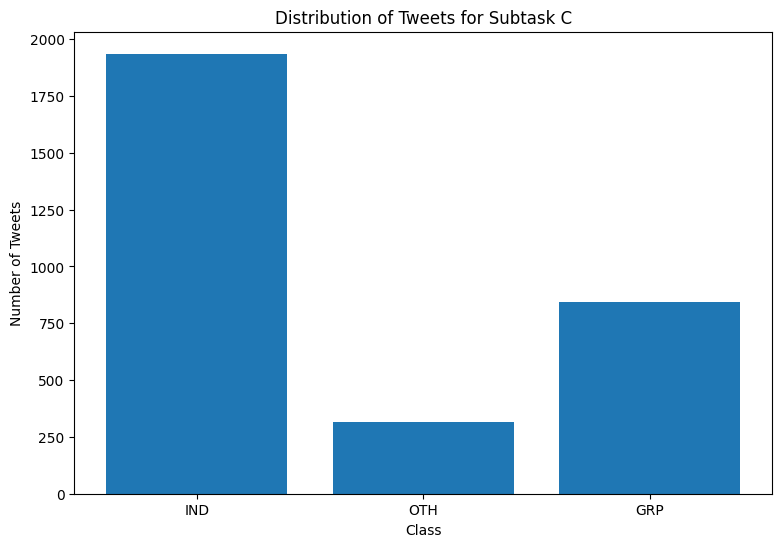

In [ ]:
C_LABELS = train_df["subtask_c"].unique().tolist()
# c_LABELS
fig = plt.figure(figsize=(9, 6))
y = [(train_df['subtask_c'] == label).sum() for label in C_LABELS]
print(y)
# ax.bar(A_LABELS, y)
plt.bar(C_LABELS, y)
plt.xlabel("Class")
plt.ylabel("Number of Tweets")
plt.title("Distribution of Tweets for Subtask C")
plt.show()

We can see that IND completely dominates the the other two classes. This will be dealt by undersampling to the number of GRP samples, whilst the OTH class will be over sampled to the number GRP samples.

In [ ]:
numOfINDTweets = (train_df['subtask_c'] == "IND").sum()
numOfOTHTweets = (train_df['subtask_c'] == "OTH").sum()
numOfGRPTweets = (train_df['subtask_c'] == "GRP").sum()

print("Number of Tweets Per Class")
print("IND: ", numOfINDTweets)
print("OTH: ", numOfOTHTweets)
print("GRP: ", numOfGRPTweets)

Number of Tweets Per Class
IND:  1936
OTH:  316
GRP:  845


Under-sample IND Class:

In [ ]:
sampleIND = train_df[train_df['subtask_c']=="IND"].sample(n=numOfGRPTweets, random_state=1)
print(sampleIND.shape)

(845, 2)


Over-sample OTH Class:

In [ ]:
sampleOTH = train_df[train_df['subtask_c']=="OTH"].sample(n=numOfGRPTweets, random_state=1, replace=True)
print(sampleOTH.shape)

(845, 2)


In [ ]:
classGRP = train_df[train_df['subtask_c']=="GRP"]
classGRP.shape

(845, 2)

Combine sampled sets to produce final training set

In [ ]:
train_df = pd.concat([sampleIND, sampleOTH, classGRP]).sample(frac = 1)
print(train_df.shape)
train_df.head()

(2535, 2)


,cleaned_tweet,subtask_c
12186,democrats double sided hypocrisy surpise maga ...,OTH
2757,elder owen bravest pointing culture part probl...,GRP
4956,endpc teaching guide portland public schools c...,OTH
9161,lives chicago thinks gun control works,OTH
7426,long ass blog might make sense,OTH


[845, 845, 845]


Text(0.5, 1.0, 'Distribution of Tweets for Subtask C')

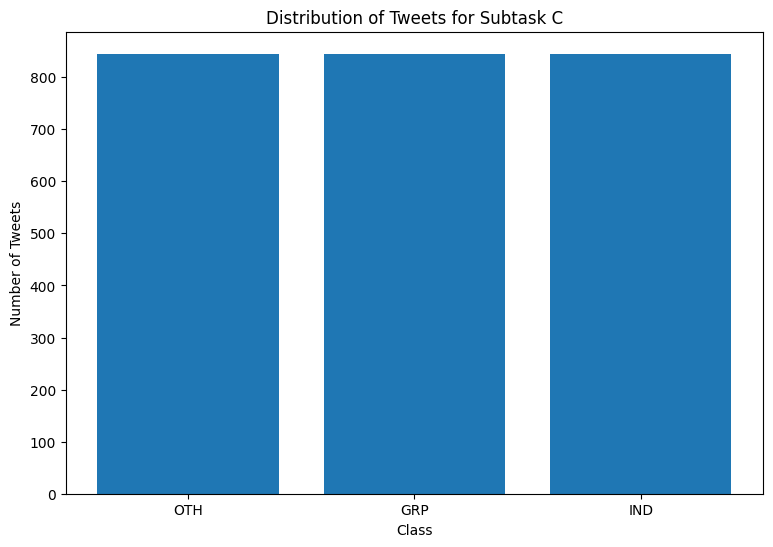

In [ ]:
C_LABELS = train_df["subtask_c"].unique().tolist()
# A_LABELS
fig = plt.figure(figsize=(9, 6))
y = [(train_df['subtask_c'] == label).sum() for label in train_df["subtask_c"].unique().tolist()]
# print(y)
# ax.bar(c_LABELS, y)
plt.bar(C_LABELS, y)
plt.xlabel("Class")
plt.ylabel("Number of Tweets")
plt.title("Distribution of Tweets for Subtask C")

The three classes are now balanced.

#Prepare Validation Test Set

In [ ]:
!gdown --id 1QlgeKC-VTIwP1dAtOF_TmVIVoD0VlpG-
!gdown --id 1AUCqSbJ-yYN7V7iFcNGpQ6cS1O15O6-5

/usr/local/lib/python3.9/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1QlgeKC-VTIwP1dAtOF_TmVIVoD0VlpG-
To: /content/testset-levelc.tsv
100% 32.8k/32.8k [00:00<00:00, 50.9MB/s]
/usr/local/lib/python3.9/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1AUCqSbJ-yYN7V7iFcNGpQ6cS1O15O6-5
To: /content/labels-levelc.csv
100% 2.13k/2.13k [00:00<00:00, 4.70MB/s]


In [ ]:
df1 = pd.read_csv("labels-levelc.csv", names=["id", "subtask_c"])
print(df1.shape)
df1.head()

(213, 2)


,id,subtask_c
0,15923,OTH
1,60133,GRP
2,83681,IND
3,65507,OTH
4,34263,IND


In [ ]:
df2 = pd.read_csv("testset-levelc.tsv", sep='\t')
print(df2.shape)
df2.head()

(213, 2)


,id,tweet
0,15923,#WhoIsQ #WheresTheServer #DumpNike #DECLASFISA...
1,60133,#NoPasaran: Unity demo to oppose the far-right...
2,83681,. . . What the fuck did he do this time?
3,65507,@USER Do you get the feeling he is kissing @US...
4,34263,#StopKavanaugh he is liar like the rest of the...


In [ ]:
val_df = pd.merge(df1, df2, on='id', how='outer')
print(val_df.shape)
val_df = val_df.rename(columns={"tweet": "cleaned_tweet"}) ############################
val_df.head()

(213, 3)


,id,subtask_c,cleaned_tweet
0,15923,OTH,#WhoIsQ #WheresTheServer #DumpNike #DECLASFISA...
1,60133,GRP,#NoPasaran: Unity demo to oppose the far-right...
2,83681,IND,. . . What the fuck did he do this time?
3,65507,OTH,@USER Do you get the feeling he is kissing @US...
4,34263,IND,#StopKavanaugh he is liar like the rest of the...


#Tokenizer

In [ ]:
BERT_MODEL_NAME = 'bert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(BERT_MODEL_NAME)

In [ ]:
token_counts = []

for _, row in train_df.iterrows():
  count = len(tokenizer.encode(
    row['cleaned_tweet'], 
    max_length=512, 
    truncation=True))
  token_counts.append(count)
  

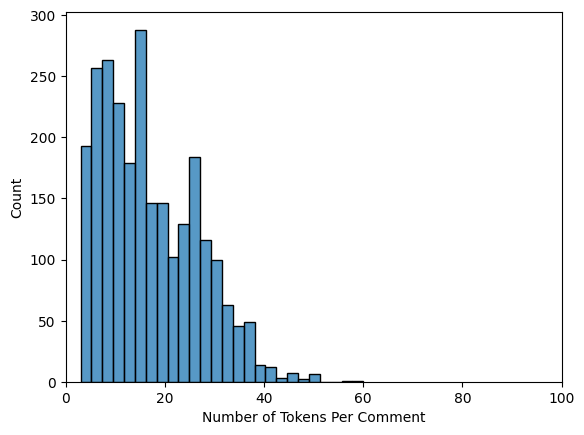

In [ ]:
sns.histplot(token_counts)
plt.xlabel("Number of Tokens Per Comment")
plt.xlim([0, 100]);

Set MAX_TOKEN_COUNT = 60

In [ ]:
MAX_TOKEN_COUNT = 60

#PyTorch Dataset

In [ ]:
def label_vector(review_label):
  vector = {label:0 for label in C_LABELS}
  vector[review_label]=1
  return list(vector.values())

In [ ]:
class TweetDataset(Dataset):
  def __init__(self, data: pd.DataFrame, tokenizer: AutoTokenizer, max_token_len: int=128):
    self.data = data
    self.tokenizer = tokenizer
    self.max_token_len = max_token_len

  def __len__(self):
    return len(self.data)
  
  ## return encoding of review
  def __getitem__ (self, index: int):
    data_row = self.data.iloc[index]
    review = data_row['cleaned_tweet']
    label = data_row['subtask_c']
    encoding = self.tokenizer.encode_plus(
        review,
        add_special_tokens=True,
        max_length=self.max_token_len,
        return_token_type_ids=False,
        padding="max_length",
        truncation=True,
        return_attention_mask=True,
        return_tensors="pt"
    )

    return dict(
        review=review,
        input_ids=encoding["input_ids"].flatten(),
        attention_mask=encoding["attention_mask"].flatten(),
        label=torch.FloatTensor(label_vector(label))
    )    

Set up PyTorch DataModule

The final step is to wrap our dataset into a lightningDataModule

In [ ]:
class TweetDataModule(pl.LightningDataModule):
  def __init__(self, train_df, test_df, tokenizer, batch_size=8, max_token_len=128):
    super().__init__()
    self.train_df = train_df
    self.test_df = test_df
    self.tokenizer = tokenizer
    self.batch_size = batch_size
    self.max_token_len = max_token_len

  # create dataset for each of the training and test sets
  def setup(self, stage=None):
    self.train_dataset = TweetDataset(
        self.train_df,
        self.tokenizer,
        self.max_token_len
    )
    self.test_dataset = TweetDataset(
        self.test_df,
        self.tokenizer,
        self.max_token_len
    )

  def train_dataloader(self):
    return DataLoader(
        self.train_dataset,
        batch_size=self.batch_size,
        shuffle=True,
        num_workers=4
    )
    
  # make predictions on a single example (single batch size)
  def val_dataloader(self):
    return DataLoader(
        self.test_dataset,
        batch_size=self.batch_size,
        num_workers=4
    )
  
  def test_dataloader(self):
    return DataLoader(
        self.test_dataset,
        batch_size=self.batch_size,
        num_workers=4
    )

#Build Model

In [ ]:
from torch.optim import lr_scheduler
class OffensiveTweetTagger(pl.LightningModule):
  def __init__(self, n_classes: int, n_training_steps=None, n_warmup_steps=None):
    super().__init__()
    self.bert = BertModel.from_pretrained(BERT_MODEL_NAME, return_dict=True)
    # classifier: serve as a way to get the output of the BERT model and convert those into the num of classes which we want to predict
    self.classifier1 = nn.Linear(self.bert.config.hidden_size, 16)
    self.dropOutLayer = nn.Dropout(p=0.1)
    self.relu = nn.ReLU()
    self.n_training_steps = n_training_steps
    self.n_warmup_steps = n_warmup_steps
    self.classifier2 = nn.Linear(16, n_classes)
    # This criterion computes the cross entropy loss between input logits and target
    self.criterion = nn.BCELoss()

  def forward(self, input_ids, attention_mask, labels=None):
    output = self.bert(input_ids, attention_mask=attention_mask)
    # run linear layer ontop of the output
    output = self.classifier1(output.pooler_output)
    output = self.relu(output)
    output = self.dropOutLayer(output)
    output = self.classifier2(output)
    # apply sigmoid function
    output = torch.sigmoid(output)
    loss = 0
    if labels is not None:
      loss = self.criterion(output, labels)
    return loss, output

  def training_step(self, batch, batch_idx):
    input_ids = batch['input_ids']
    attention_mask = batch['attention_mask']
    labels = batch['label']
    loss, outputs = self.forward(input_ids, attention_mask, labels)
    # output training loss
    self.log("train_loss", loss, prog_bar=True, logger=True)
    return {"loss": loss, "predictions": outputs, "labels": labels}

  def validation_step(self, batch, batch_idx):
    input_ids = batch['input_ids']
    attention_mask = batch['attention_mask']
    labels = batch['label']
    loss, outputs = self.forward(input_ids, attention_mask, labels)
    # output training loss
    self.log("val_loss", loss, prog_bar=True, logger=True)
    return loss
  
  def test_step(self, batch, batch_idx):
    input_ids = batch['input_ids']
    attention_mask = batch['attention_mask']
    labels = batch['label']
    loss, outputs = self.forward(input_ids, attention_mask, labels)
    # output training loss
    self.log("test_loss", loss, prog_bar=True, logger=True)
    return loss

  # configer optimisers and learning rate scheduler
  def configure_optimizers(self):
    # fine tuning recomendations from original BERT paper
    # Recommended learning rates (Adam): 5e-5, 3e-5, 2e-5. See: https://arxiv.org/pdf/1810.04805.pdf
    optimizer = AdamW(self.parameters(), lr=5e-5)
  
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=self.n_warmup_steps,
        num_training_steps=self.n_training_steps
    )

    # return a list of optimisers and schedulers
    return dict(
        optimizer=optimizer,
        lr_scheduler=dict(
            scheduler=scheduler,
            interval='step'
        )
    )

If we simulate 100 training steps and tell the scheduler to warm up for the first 20. The learning rate grows to the initial fixed value of 0.001 during the warm-up and then goes down (linearly) to 0.

To use the scheduler, we need to calculate the number of training and warm-up steps. The number of training steps per epoch is equal to number of training examples / batch size. The number of total training steps is training steps per epoch * number of epochs:

#Training

In [ ]:
train_df

,cleaned_tweet,subtask_a
0,ask native americans take,1
1,go home drunk maga trump 2020,1
3,someone vetaken piece shit volcano,1
5,liberals kookoo,1
6,oh noes tough shit,1
...,...,...
5460,loyal maga followers need read,0
9400,one cares,0
6675,pretend care women attacking conservatives cou...,0
8270,kirk douglas,0


Load Model

In [ ]:
# Recommended batch size: 16, 32. See: https://arxiv.org/pdf/1810.04805.pdf
# Select hyperparameters based on the recommendations from the BERT paper¹:

# The optimal hyperparameter values are task-specific, but we found the following range of possible values to work well across all tasks:

# - Batch size: 16, 32

# - Learning rate (Adam): 5e-5, 3e-5, 2e-5

# - Number of epochs: 2, 3, 4

N_EPOCHS = 4
BATCH_SIZE = 16
MAX_TOKEN_COUNT = 60
THRESHOLD = 0.5
BERT_MODEL_NAME = 'bert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(BERT_MODEL_NAME)

accuracies = []

train_df_fold, val_df_fold = train_test_split(train_df, test_size=0.20)

data_module = TweetDataModule(
    train_df_fold,
    val_df_fold,
    tokenizer,
    batch_size=BATCH_SIZE,
    max_token_len=MAX_TOKEN_COUNT
)

steps_per_epoch = len(train_df_fold) // BATCH_SIZE
total_training_steps = steps_per_epoch * N_EPOCHS
warmup_steps = total_training_steps // 5

model = OffensiveTweetTagger(
  n_classes=len(C_LABELS),
  n_warmup_steps=warmup_steps,
  n_training_steps=total_training_steps
)

# Run on GPU
model.cuda()

checkpoint_callback = ModelCheckpoint(
  dirpath="subtask_C/train-test_split",
  filename="best-checkpoint",
  save_top_k=1,
  verbose=True,
  monitor="val_loss",
  mode="min",
  save_weights_only=True
)

early_stopping_callback = EarlyStopping(monitor='val_loss', patience=2)

trainer = pl.Trainer(
  callbacks=[early_stopping_callback, checkpoint_callback],
  max_epochs=N_EPOCHS
)

trainer.fit(model, data_module)
trainer.test(model, data_module)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

val_dataset = TweetDataset(
  val_df,
  tokenizer,
  max_token_len=MAX_TOKEN_COUNT
)

predictions = []
labels = []

with torch.no_grad(): 
  for item in tqdm(val_dataset):
    input_ids = item["input_ids"].unsqueeze(dim=0)
    attention_mask = item["attention_mask"].unsqueeze(dim=0)
    input_ids.to(device)
    attention_mask.to(device)
    _, prediction = model(
      input_ids,
      attention_mask
    )
    predictions.append(prediction.flatten())
    labels.append(item["label"].int())

  predictions = torch.stack(predictions).detach().cpu()
  labels = torch.stack(labels).detach().cpu()
  

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 127: 'val_loss' reached 0.56430 (best 0.56430), saving model to '/content/subtask_C/train-test_split/best-checkpoint.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 254: 'val_loss' reached 0.49930 (best 0.49930), saving model to '/content/subtask_C/train-test_split/best-checkpoint.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 2, global step 381: 'val_loss' reached 0.37828 (best 0.37828), saving model to '/content/subtask_C/train-test_split/best-checkpoint.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 3, global step 508: 'val_loss' reached 0.35678 (best 0.35678), saving model to '/content/subtask_C/train-test_split/best-checkpoint.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=4` reached.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.3567843437194824     │
└───────────────────────────┴───────────────────────────┘

  0%|          | 0/213 [00:00<?, ?it/s]

Accuracy:  tensor(0.)


In [ ]:
# output Accuracy
model_accuracy = accuracy(task="multilabel", num_labels=len(C_LABELS), preds=predictions, target=labels, threshold=THRESHOLD)
print("Accuracy: ", model_accuracy)

Accuracy:  tensor(0.7512)


In [ ]:
y_pred = predictions.numpy()
y_true = labels.numpy()

upper, lower = 1, 0

y_pred = np.where(y_pred > 0.5, upper, lower)

print(classification_report(
  y_true,
  y_pred,
  target_names=C_LABELS,
  zero_division=0
))

              precision    recall  f1-score   support

         OTH       0.28      0.14      0.19        35
         GRP       0.59      0.81      0.68        78
         IND       0.84      0.52      0.64       100

   micro avg       0.65      0.56      0.60       213
   macro avg       0.57      0.49      0.51       213
weighted avg       0.66      0.56      0.58       213
 samples avg       0.55      0.56      0.56       213



We gain exremeply poor results for generalising OTH. This is probably due to over-sampling this set which has made the model over-fit to it.

# Load in Saved Model


In [ ]:
trained_model = OffensiveTweetTagger.load_from_checkpoint(
  "./subtask_C/train-test_split/best-checkpoint.ckpt",
  n_classes=len(C_LABELS)
)
trained_model.eval()
trained_model.freeze()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


## Predicting unseen tweet using the trained model

In [ ]:
test_tweet= "#Cuckservative Traitors Are Worse Than Fortnite Players URL #Conservatives #TriggerWarningRadio"

encoding = tokenizer.encode_plus(
    test_tweet,
    add_special_tokens=True,
    max_length=400,
    return_token_type_ids=False,
    padding="max_length",
    return_attention_mask=True,
    return_tensors='pt',
)

trained_model.to('cpu')
encoding.to('cpu')

_, test_prediction = trained_model(encoding['input_ids'], encoding['attention_mask'])
test_prediction = test_prediction.flatten().numpy()

In [ ]:
test_prediction[test_prediction.argmax()] = 1

print("Tweet: ", test_tweet)
if (test_prediction[0]==1):
  print("Result: This tweet is targeted at an INDividual")
elif (test_prediction[1]==1):
  print("Result: This tweet is targeted at OTH than an individual or group")
else:
  print("Result: This tweet is targeted at a Group (GRP)")
    

Tweet:  #Cuckservative Traitors Are Worse Than Fortnite Players URL #Conservatives #TriggerWarningRadio
Result: This tweet is targeted at OTH than an individual or group
